# Data wrangling WeRateDogs

## CONTENTS
- [Introduction](#introduction)
- [Gathering data](#gathering)
   - [Twitter Archive File(.csv)](#Twitter_Archive)
   - [Image Predictions File (.tsv)](#Image_Predictions)
   - [Twitter API](#Twitter_API)
- [Assessing data](#assessing)
   - [Visual assessing](#visual)
   - [Programmatical assessing](#prog)
   - [Documanting issues](#doc)
- [Cleaning data](#cleaning)
   - [Fixing quality issues](#quality)
   - [Fixing Tidness issues](#Tidy)
- [Storing](#storing)
- [Analyzing, and Visualizing](#visual_analysis)
   - [Insight one & visualization](#one)
   - [Insight two](#two)
   - [Insight three & visualization](#three)
   - [Insight four & visualization](#four)

<a id='introduction'></a>
# INTRODUCTION
The dataset that you will be wrangling (and analyzing and visualizing) is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. WeRateDogs has over 4 million followers and has received international media coverage.

In [1]:
# importing the required libraries
import requests
import os
import re
import tweepy 
from tweepy import OAuthHandler
import json 
import seaborn as sns
import pandas as pd
import numpy as np
from functools import reduce
from datetime import datetime
from timeit import default_timer as timer
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
%matplotlib inline

<a id='gathering'></a>
# GARTHERING DATA
Data is successfully gathered from three different sources. Each piece of data is imported into a separate pandas DataFrame at first.

<a id='Twitter_Archive'></a>
## 1. Twitter Archive File(.csv)
WeRateDogs downloaded their Twitter archive and shared it exclusively for use in this project. This archive contains basic tweet data (tweet ID, timestamp, text, etc.) for all 5000+ of their tweets as they stood on August 1, 2017.


In [2]:
# This was extracted programmatically by Udacity and provided as a csv file to use.
df_Twitter_Archive = pd.read_csv('twitter-archive-enhanced-2.csv')

In [3]:
df_Twitter_Archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

<a id='Image_Predictions'></a>
## 2.  Image Predictions File (.tsv)
* The tweet image predictions, i.e., what breed of dog is present in each tweet according to a neural network is stored in this file. 
* It was hosted on Udacity’s servers in *'tsv'* format and had to be downloaded programmatically using the Url. 
* Python’s request library was used to gather this data from the web. Requests is a versatile HTTP library in python with various applications. One of its applications is to download or open a file from web using the file URL.



In [4]:
#(1) Garther the data from the Udacity's servers
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
# http response
response = requests.get(url)
response

<Response [200]>

In [5]:
#(2) write the content of the server in my new file 
file_name = url.split('/')[-1]
if not os.path.exists(file_name):
    os.makedirs(file_name)
with open(file_name, mode = 'wb' ) as file:
    file.write(response.content)

In [6]:
#(3) Read tsv file
image_prediction = pd.read_csv('image-predictions.tsv', sep='\t' )

In [7]:
image_prediction.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


<a id='Twitter_API'></a>
## 3. Twitter API
* Using the tweet IDs in the WeRateDogs Twitter archive, query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called *'tweet_json.txt'* file. 
* Each tweet's JSON data should be written to its own line.
* Each tweet’s retweet count and favorite ("like") count at minimum, and any additional data you find interesting.

In [8]:
consumer_key = 'MoYH3xx0XiMye5dLSL1lzNZGB'
consumer_secret = 'XUlZ8SIwcJ4RomopHpNdxWDbCNTlDxmn1g9EOMQ76GHP5KNddf'
access_token = '1073711682650890243-yV8jin1tdsHOFubSsUFzMHkc14eOvb'
access_secret = 'B7eiG8RnfUHDd97gfyTNAGZklxlD0P5rLyqnxX1GFFRrB'

# Tweets that can't be found are saved in this list 
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

In [9]:
tweet_ids = df_Twitter_Archive.tweet_id.values
print ( 'number of tweets = ',len(tweet_ids),'\n' )
list ( tweet_ids)

number of tweets =  2356 



[892420643555336193,
 892177421306343426,
 891815181378084864,
 891689557279858688,
 891327558926688256,
 891087950875897856,
 890971913173991426,
 890729181411237888,
 890609185150312448,
 890240255349198849,
 890006608113172480,
 889880896479866881,
 889665388333682689,
 889638837579907072,
 889531135344209921,
 889278841981685760,
 888917238123831296,
 888804989199671297,
 888554962724278272,
 888202515573088257,
 888078434458587136,
 887705289381826560,
 887517139158093824,
 887473957103951883,
 887343217045368832,
 887101392804085760,
 886983233522544640,
 886736880519319552,
 886680336477933568,
 886366144734445568,
 886267009285017600,
 886258384151887873,
 886054160059072513,
 885984800019947520,
 885528943205470208,
 885518971528720385,
 885311592912609280,
 885167619883638784,
 884925521741709313,
 884876753390489601,
 884562892145688576,
 884441805382717440,
 884247878851493888,
 884162670584377345,
 883838122936631299,
 883482846933004288,
 883360690899218434,
 883117836046

### Test Tweet

In [10]:
exp_tweet = api.get_status(df_Twitter_Archive.tweet_id[1000], tweet_mode = 'extended')
content = exp_tweet._json
print(content)

{'created_at': 'Wed Jun 29 01:23:16 +0000 2016', 'id': 747963614829678593, 'id_str': '747963614829678593', 'full_text': 'PUPPER NOOOOO BEHIND YOUUU 10/10 pls keep this pupper in your thoughts https://t.co/ZPfeRtOX0Q', 'truncated': False, 'display_text_range': [0, 70], 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 747963600220917761, 'id_str': '747963600220917761', 'indices': [71, 94], 'media_url': 'http://pbs.twimg.com/media/CmFM7ngXEAEitfh.jpg', 'media_url_https': 'https://pbs.twimg.com/media/CmFM7ngXEAEitfh.jpg', 'url': 'https://t.co/ZPfeRtOX0Q', 'display_url': 'pic.twitter.com/ZPfeRtOX0Q', 'expanded_url': 'https://twitter.com/dog_rates/status/747963614829678593/photo/1', 'type': 'photo', 'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'medium': {'w': 937, 'h': 632, 'resize': 'fit'}, 'small': {'w': 680, 'h': 459, 'resize': 'fit'}, 'large': {'w': 937, 'h': 632, 'resize': 'fit'}}}]}, 'extended_entities': {'media': [{'id': 74796

In [11]:
content.keys()

dict_keys(['created_at', 'id', 'id_str', 'full_text', 'truncated', 'display_text_range', 'entities', 'extended_entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'possibly_sensitive_appealable', 'lang'])

In [12]:
print("retweet_count = ",content['retweet_count'],'\n')
print("id = ",content['id'],'\n')
print("favorite count = ",content['favorite_count'],'\n')
print("user followers count = " , content['user']['followers_count'],'\n')

retweet_count =  2078 

id =  747963614829678593 

favorite count =  5647 

user followers count =  8927597 



### Query Twitter's API for JSON data for each tweet ID in the Twitter archive

In [13]:
num_of_tweet = 0
# key = id , value = type of exception
exception_dict = {}
#file path
file_name = 'tweet-json.txt'

In [14]:
# Save each tweet's returned JSON as a new line in a .txt file
start = timer()
with open(file_name, 'w') as file:
    for _id in tweet_ids:
        num_of_tweet += 1
        print(str(num_of_tweet) + ": " + str(_id))
        try:
            tweet = api.get_status(_id, wait_on_rate_limit=True,  wait_on_rate_limit_notify=True, tweet_mode='extended')
            json.dump(tweet._json, file)
            file.write('\n')
            print("Successs ^_^")
        except tweepy.TweepError as e:
            print("Error on tweet id {}".format(_id) + ";" + str(e))
            exception_dict[_id] = e
            pass
end = timer()
print(end - start)

1: 892420643555336193
Successs ^_^
2: 892177421306343426
Successs ^_^
3: 891815181378084864
Successs ^_^
4: 891689557279858688
Successs ^_^
5: 891327558926688256
Successs ^_^
6: 891087950875897856
Successs ^_^
7: 890971913173991426
Successs ^_^
8: 890729181411237888
Successs ^_^
9: 890609185150312448
Successs ^_^
10: 890240255349198849
Successs ^_^
11: 890006608113172480
Successs ^_^
12: 889880896479866881
Successs ^_^
13: 889665388333682689
Successs ^_^
14: 889638837579907072
Successs ^_^
15: 889531135344209921
Successs ^_^
16: 889278841981685760
Successs ^_^
17: 888917238123831296
Successs ^_^
18: 888804989199671297
Successs ^_^
19: 888554962724278272
Successs ^_^
20: 888202515573088257
Error on tweet id 888202515573088257;[{'code': 144, 'message': 'No status found with that ID.'}]
21: 888078434458587136
Successs ^_^
22: 887705289381826560
Successs ^_^
23: 887517139158093824
Successs ^_^
24: 887473957103951883
Successs ^_^
25: 887343217045368832
Successs ^_^
26: 887101392804085760
Su

Rate limit reached. Sleeping for: 59


Successs ^_^
901: 758740312047005698
Successs ^_^
902: 758474966123810816
Successs ^_^
903: 758467244762497024
Successs ^_^
904: 758405701903519748
Successs ^_^
905: 758355060040593408
Successs ^_^
906: 758099635764359168
Successs ^_^
907: 758041019896193024
Successs ^_^
908: 757741869644341248
Successs ^_^
909: 757729163776290825
Successs ^_^
910: 757725642876129280
Successs ^_^
911: 757611664640446465
Successs ^_^
912: 757597904299253760
Successs ^_^
913: 757596066325864448
Successs ^_^
914: 757400162377592832
Successs ^_^
915: 757393109802180609
Successs ^_^
916: 757354760399941633
Successs ^_^
917: 756998049151549440
Successs ^_^
918: 756939218950160384
Successs ^_^
919: 756651752796094464
Successs ^_^
920: 756526248105566208
Successs ^_^
921: 756303284449767430
Successs ^_^
922: 756288534030475264
Successs ^_^
923: 756275833623502848
Successs ^_^
924: 755955933503782912
Successs ^_^
925: 755206590534418437
Successs ^_^
926: 755110668769038337
Successs ^_^
927: 754874841593970688
S

Rate limit reached. Sleeping for: 314


Successs ^_^
1801: 676975532580409345
Successs ^_^
1802: 676957860086095872
Successs ^_^
1803: 676949632774234114
Successs ^_^
1804: 676948236477857792
Successs ^_^
1805: 676946864479084545
Successs ^_^
1806: 676942428000112642
Successs ^_^
1807: 676936541936185344
Successs ^_^
1808: 676916996760600576
Successs ^_^
1809: 676897532954456065
Successs ^_^
1810: 676864501615042560
Successs ^_^
1811: 676821958043033607
Successs ^_^
1812: 676819651066732545
Successs ^_^
1813: 676811746707918848
Successs ^_^
1814: 676776431406465024
Successs ^_^
1815: 676617503762681856
Successs ^_^
1816: 676613908052996102
Successs ^_^
1817: 676606785097199616
Successs ^_^
1818: 676603393314578432
Successs ^_^
1819: 676593408224403456
Successs ^_^
1820: 676590572941893632
Successs ^_^
1821: 676588346097852417
Successs ^_^
1822: 676582956622721024
Successs ^_^
1823: 676575501977128964
Successs ^_^
1824: 676533798876651520
Successs ^_^
1825: 676496375194980353
Successs ^_^
1826: 676470639084101634
Successs ^_^

In [15]:
print(round((end - start)/60) , 'min')

36 min


### Convert file to dataframe

In [16]:
#list of dicts
tweet_list = []
with open(file_name, 'r') as file:
    for line in file:
        tweet = json.loads(line)
        tweet_list.append({'id': tweet['id'],  
                            'full_text':tweet['full_text'],
                            'retweet_count':tweet['retweet_count'],
                            'favorite_count':tweet['favorite_count'],
                            'friends_count':tweet['user']['friends_count'],
                            'followers_count':tweet['user']['followers_count'],
                            'source':tweet['source']
                         })
        
Api_df = pd.DataFrame(tweet_list , columns = ['id','full_text','retweet_count', 'favorite_count', 'followers_count','source'])

-------------

<a id='assessing'></a>
# ASSESSING DATA
Inspection our collected data sets from both the quality and tidiness per

<a id='visual'></a>
## Visual assessing

In [17]:
pd.set_option('display.max_rows',None)
pd.set_option('display.max_colwidth', 50)

df_Twitter_Archive.sample(50)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
789,773985732834758656,NaN,NaN,2016-09-08 20:45:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Winnie. She just made awkward eye contact...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/773985732...,11,10,Winnie,None,None,pupper,None
2031,671768281401958400,NaN,NaN,2015-12-01 19:10:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you try to recreate the scene from Lady &...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671768281...,10,10,None,None,None,None,None
2195,668872652652679168,NaN,NaN,2015-11-23 19:24:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Amélie. She is a confident white colle...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668872652...,11,10,Amélie,None,None,None,None
390,826240494070030336,NaN,NaN,2017-01-31 01:27:39 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. Please don't send in any mo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/826240494...,11,10,None,None,None,None,None
484,814638523311648768,NaN,NaN,2016-12-30 01:05:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Olivia. She's a passionate advocate of...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/814638523...,12,10,Olivia,None,None,None,None
432,820749716845686786,NaN,NaN,2017-01-15 21:49:15 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sunny. He can take down a polar bear in o...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820749716...,13,10,Sunny,None,None,None,None
282,839239871831150596,NaN,NaN,2017-03-07 22:22:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Odie. He's big. 13/10 would attempt to...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/839239871...,13,10,Odie,None,None,None,None
2234,668190681446379520,NaN,NaN,2015-11-21 22:14:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Skittles. I would kidnap Skittles. Pin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668190681...,12,10,Skittles,None,None,None,None
1092,737322739594330112,NaN,NaN,2016-05-30 16:40:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Lily. She's not injured or anythi...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/737322739...,9,10,Lily,None,None,None,None
1210,715680795826982913,NaN,NaN,2016-03-31 23:22:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zeus. He's downright fabulous. 12/10 h...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/715680795...,12,10,Zeus,None,None,None,None


In [18]:
df_Twitter_Archive.timestamp.sample(5)

1742    2015-12-23 00:45:35 +0000
888     2016-07-31 20:21:02 +0000
1583    2016-01-13 02:43:46 +0000
658     2016-10-27 16:06:04 +0000
1005    2016-06-28 04:42:46 +0000
Name: timestamp, dtype: object

In [19]:
image_prediction.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1924,857263160327368704,https://pbs.twimg.com/media/C-WcS4MXoAADrBU.jpg,1,Samoyed,0.998021,True,Pomeranian,0.000922,True,keeshond,0.000311,True
2003,877201837425926144,https://pbs.twimg.com/media/DCxyahJWsAAddSC.jpg,1,Pembroke,0.931120,True,Cardigan,0.068698,True,basenji,0.000082,True
58,667090893657276420,https://pbs.twimg.com/media/CUH7oLuUsAELWib.jpg,1,Chihuahua,0.959514,True,Italian_greyhound,0.005370,True,Pomeranian,0.002641,True
602,679828447187857408,https://pbs.twimg.com/media/CW88XN4WsAAlo8r.jpg,3,Chihuahua,0.346545,True,dalmatian,0.166246,True,toy_terrier,0.117502,True
1654,810254108431155201,https://pbs.twimg.com/media/Cz6Z0DgWIAAfdvp.jpg,1,Staffordshire_bullterrier,0.292556,True,American_Staffordshire_terrier,0.261233,True,Border_terrier,0.062375,True
534,676936541936185344,https://pbs.twimg.com/media/CWT2MUgWIAECWig.jpg,1,Chesapeake_Bay_retriever,0.545286,True,Norwegian_elkhound,0.081482,True,space_heater,0.047391,False
1907,852553447878664193,https://pbs.twimg.com/media/C9Tg1bPW0AkAMDI.jpg,1,bloodhound,0.186498,True,Brabancon_griffon,0.139028,True,Rottweiler,0.125940,True
1662,811985624773361665,https://pbs.twimg.com/media/C0TAnZIUAAAADKs.jpg,1,Staffordshire_bullterrier,0.610573,True,French_bulldog,0.159935,True,doormat,0.058672,False
1188,739544079319588864,https://pbs.twimg.com/media/CkNjahBXAAQ2kWo.jpg,1,Labrador_retriever,0.967397,True,golden_retriever,0.016641,True,ice_bear,0.014858,False
624,680609293079592961,https://pbs.twimg.com/media/CXICiB9UwAE1sKY.jpg,1,French_bulldog,0.700764,True,Chihuahua,0.072390,True,American_Staffordshire_terrier,0.039619,True


In [20]:
Api_df.sample(5)

,id,full_text,retweet_count,favorite_count,followers_count,source
92,874057562936811520,"I can't believe this keeps happening. This, is...",3543,20942,8927627,"<a href=""http://twitter.com/download/iphone"" r..."
2231,667766675769573376,This is Calvin. He is a Luxembourgian Mayo. Ha...,201,405,8927749,"<a href=""http://twitter.com"" rel=""nofollow"">Tw..."
2325,666050758794694657,This is a truly beautiful English Wilson Staff...,51,119,8927752,"<a href=""http://twitter.com/download/iphone"" r..."
943,750381685133418496,13/10 such a good doggo\n@spaghemily,27,682,8927684,"<a href=""http://twitter.com/download/iphone"" r..."
2198,668297328638447616,2 rare dogs. They waddle (v inefficient). Some...,274,582,8927747,"<a href=""http://twitter.com/download/iphone"" r..."


<a id='prog'></a>
## Programmatical assessing

### Twitter Archive data

In [21]:
df_Twitter_Archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [22]:
print (df_Twitter_Archive['doggo'].value_counts() , '\n')
print (df_Twitter_Archive['floofer'].value_counts() , '\n')
print (df_Twitter_Archive['pupper'].value_counts() , '\n')
print (df_Twitter_Archive['puppo'].value_counts() , '\n')

None     2259
doggo      97
Name: doggo, dtype: int64 

None       2346
floofer      10
Name: floofer, dtype: int64 

None      2099
pupper     257
Name: pupper, dtype: int64 

None     2326
puppo      30
Name: puppo, dtype: int64 



In [23]:
sum(df_Twitter_Archive['tweet_id'].duplicated())

0

In [24]:
retweet_count= sum(~df_Twitter_Archive['retweeted_status_id'].isnull())
print('number of retweets = ',retweet_count)

number of retweets =  181


In [25]:
df_Twitter_Archive.rating_numerator.describe()

count    2356.000000
mean       13.126486
std        45.876648
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating_numerator, dtype: float64

In [26]:
df_Twitter_Archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [27]:
numerator = [420,165,144,182,143,666,960,1776]
for n in numerator:
    print(df_Twitter_Archive.loc[df_Twitter_Archive['rating_numerator'] == n , 'text'],'\n')

188     @dhmontgomery We also gave snoop dogg a 420/10...
2074    After so many requests... here you go.\n\nGood...
Name: text, dtype: object 

902    Why does this never happen at my front door......
Name: text, dtype: object 

1779    IT'S PUPPERGEDDON. Total of 144/120 ...I think...
Name: text, dtype: object 

290    @markhoppus 182/10
Name: text, dtype: object 

1634    Two sneaky puppers were not initially seen, mo...
Name: text, dtype: object 

189    @s8n You tried very hard to portray this good ...
Name: text, dtype: object 

313    @jonnysun @Lin_Manuel ok jomny I know you're e...
Name: text, dtype: object 

979    This is Atticus. He's quite simply America af....
Name: text, dtype: object 



In [28]:
df_Twitter_Archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [29]:
demo = [11,50,80,20,2,16,40,70,15,90,110,120,130,150,170,7,0]
for n in demo:
    print(df_Twitter_Archive.loc[df_Twitter_Archive['rating_denominator'] == n , 'text'],'\n')

784     RT @dog_rates: After so many requests, this is...
1068    After so many requests, this is Bretagne. She ...
1662    This is Darrel. He just robbed a 7/11 and is i...
Name: text, dtype: object 

1202    This is Bluebert. He just saw that both #Final...
1274    From left to right:\nCletus, Jerome, Alejandro...
1351    Here is a whole flock of puppers.  60/50 I'll ...
Name: text, dtype: object 

1254    Here's a brigade of puppers. All look very pre...
1843    Here we have an entire platoon of puppers. Tot...
Name: text, dtype: object 

1165    Happy 4/20 from the squad! 13/10 for all https...
1598    Yes I do realize a rating of 4/20 would've bee...
Name: text, dtype: object 

2335    This is an Albanian 3 1/2 legged  Episcopalian...
Name: text, dtype: object 

1663    I'm aware that I could've said 20/16, but here...
Name: text, dtype: object 

1433    Happy Wednesday here's a bucket of pups. 44/40...
Name: text, dtype: object 

433    The floofs have been released I repeat the 

In [30]:
df_Twitter_Archive['text'][313] #demo = 0

"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho"

In [31]:
mask = df_Twitter_Archive.name.str.islower() 
df_Twitter_Archive[mask].name.tolist()

['such',
 'a',
 'quite',
 'quite',
 'quite',
 'not',
 'one',
 'incredibly',
 'a',
 'mad',
 'an',
 'very',
 'a',
 'very',
 'just',
 'my',
 'one',
 'not',
 'his',
 'one',
 'a',
 'a',
 'a',
 'an',
 'very',
 'actually',
 'a',
 'just',
 'getting',
 'mad',
 'very',
 'this',
 'unacceptable',
 'all',
 'a',
 'old',
 'a',
 'infuriating',
 'a',
 'a',
 'a',
 'an',
 'a',
 'a',
 'very',
 'getting',
 'just',
 'a',
 'the',
 'the',
 'actually',
 'by',
 'a',
 'officially',
 'a',
 'the',
 'the',
 'a',
 'a',
 'a',
 'a',
 'life',
 'a',
 'one',
 'a',
 'a',
 'a',
 'light',
 'just',
 'space',
 'a',
 'the',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'an',
 'a',
 'the',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'quite',
 'a',
 'an',
 'a',
 'an',
 'the',
 'the',
 'a',
 'a',
 'an',
 'a',
 'a',
 'a',
 'a']

### Image prediction data

In [32]:
image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [33]:
image_prediction.shape

(2075, 12)

In [34]:
image_prediction.nunique()

tweet_id    2075
jpg_url     2009
img_num        4
p1           378
p1_conf     2006
p1_dog         2
p2           405
p2_conf     2004
p2_dog         2
p3           408
p3_conf     2006
p3_dog         2
dtype: int64

In [35]:
sum(image_prediction.jpg_url.duplicated())

66

In [36]:
image_prediction.p1_conf.describe()

count    2075.000000
mean        0.594548
std         0.271174
min         0.044333
25%         0.364412
50%         0.588230
75%         0.843855
max         1.000000
Name: p1_conf, dtype: float64

In [37]:
print ('number of true prediction in P1 : ', sum(image_prediction.p1_dog))
print ('number of true prediction in P2 : ', sum(image_prediction.p2_dog))
print ('number of true prediction in P3 : ', sum(image_prediction.p3_dog))

number of true prediction in P1 :  1532
number of true prediction in P2 :  1553
number of true prediction in P3 :  1499


### Twitter API data

In [38]:
Api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               2331 non-null   int64 
 1   full_text        2331 non-null   object
 2   retweet_count    2331 non-null   int64 
 3   favorite_count   2331 non-null   int64 
 4   followers_count  2331 non-null   int64 
 5   source           2331 non-null   object
dtypes: int64(4), object(2)
memory usage: 109.4+ KB


In [39]:
Api_df.nunique()

id                 2331
full_text          2331
retweet_count      1668
favorite_count     1981
followers_count     161
source                4
dtype: int64

In [40]:
Api_df.retweet_count.value_counts()

51       5
651      5
267      5
710      5
489      5
3786     4
1456     4
902      4
439      4
433      4
360      4
214      4
3111     4
195      4
598      4
588      4
860      4
154      4
71       4
81       4
510      4
570      4
506      4
41       4
544      4
73       3
918      3
1032     3
934      3
5531     3
266      3
355      3
307      3
148      3
459      3
1627     3
1058     3
119      3
235      3
89       3
227      3
219      3
216      3
2262     3
213      3
1158     3
200      3
1100     3
1126     3
182      3
1154     3
201      3
2        3
336      3
624      3
1057     3
3100     3
592      3
867      3
2527     3
482      3
1031     3
1021     3
488      3
500      3
502      3
921      3
552      3
514      3
516      3
937      3
939      3
370      3
638      3
537      3
442      3
708      3
776      3
597      3
540      3
3308     3
1251     3
633      3
641      3
5309     3
1203     3
609      3
1179     3
704      3
690      3
787      3

In [41]:
Api_df.favorite_count.value_counts()

0         163
1112        4
3253        4
2250        3
749         3
1248        3
352         3
2024        3
887         3
2365        3
2091        3
693         3
1182        3
1038        3
1036        3
2168        3
3167        3
291         3
682         3
1833        3
3392        3
3361        2
1976        2
289         2
177         2
284         2
565         2
3245        2
20780       2
2602        2
1855        2
3490        2
6236        2
2355        2
1181        2
314         2
2551        2
1374        2
320         2
2749        2
5310        2
2747        2
698         2
169         2
587         2
1569        2
1041        2
3721        2
1285        2
2247        2
3173        2
7886        2
2154        2
13088       2
218         2
2267        2
1059        2
2575        2
7854        2
230         2
3060        2
1705        2
336         2
6536        2
605         2
8611        2
3084        2
3718        2
194         2
1594        2
215         2
1416  

In [42]:
Api_df.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2197
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      10
Name: source, dtype: int64

<a id='doc'></a>
## Documanting issues
### Quality
 1. [`df_Twitter_Archive` : Convert **(timestamp)** column datatype to datetime64.](#1)
 2. [`df_Twitter_Archive` : convert **(tweet_id)** column datatype to object.](#2)
 3. [`df_Twitter_Archive` : **(name)** column has invalid values.](#3) 
 4. [`df_Twitter_Archive` : convert *None* in **(name)** column to NAN.](#4) 
 5. [`df_Twitter_Archive` : drop the retweets rows then drop the retweets columns.](#5)     
 6. [`df_Twitter_Archive` : drop missing values in **(expanded_urls)** column.](#6)
 7. [`df_Twitter_Archive` : Correct denominators and numerator issues.](#7)
 
 
 8. [`image_prediction` : **(p1,p2,p3)** not descriptive column names.](#10) 
 9. [`image_prediction` : convert **(tweet_id_image)** datatype to object.](#8)
 10. [`image_prediction` : drop duplicated **(jpg_url)**.](#9)
 11. [`image_prediction` : merge the three columns **(p1,p2,p3)**.](#11)
 
 
 
 12. [`Api_df` : convert **(id)** datatype to object.](#12)
 13. [`Api_df` : drop **(full_text,followers_count,source)** columns.](#13)
 

<a id='doc'></a>
### Tidiness
 1. [`df_Twitter_Archive` : merge the four columns **(dogoo,floofer,pupper,puppo)**.](#14)
 2.	[Merge the three DataFrame in one dataset.](#15)

<a id='cleaning'></a>
# CLEAN DATA

In [43]:
# take a copy from the orignal data 
df_Twitter_Archive_clean = df_Twitter_Archive.copy()
image_prediction_clean = image_prediction.copy()
Api_df_clean = Api_df.copy()

<a id='1'></a>
### Define
Convert **(timestamp)** column datatype to datetime64 in `df_Twitter_Archive` DataFrame.
[](#1)

### Code

In [44]:
df_Twitter_Archive_clean.timestamp = pd.to_datetime(df_Twitter_Archive_clean.timestamp)

### Test

In [45]:
df_Twitter_Archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   int64              
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         181 non-null    float64            
 7   retweeted_status_user_id    181 non-null    float64            
 8   retweeted_status_timestamp  181 non-null    object             
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

<a id='2'></a>
### Define
Convert **(tweet_id)** column datatype to object in `df_Twitter_Archive` DataFrame.
[](#2)

### Code

In [46]:
df_Twitter_Archive_clean.tweet_id = df_Twitter_Archive_clean.tweet_id.astype(object)

### Test

In [47]:
df_Twitter_Archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   object             
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         181 non-null    float64            
 7   retweeted_status_user_id    181 non-null    float64            
 8   retweeted_status_timestamp  181 non-null    object             
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

<a id='3'></a>
### Define
**(name)** column has invalid values in `df_Twitter_Archive` DataFrame.
[](#3) 

In [48]:
mask = df_Twitter_Archive_clean.name.str.islower() 
res = df_Twitter_Archive_clean[mask].name.value_counts().index
print('Invalid values is : ',res)

Invalid values is :  Index(['a', 'the', 'an', 'very', 'quite', 'one', 'just', 'not', 'actually',
       'mad', 'getting', 'such', 'officially', 'unacceptable', 'my', 'all',
       'old', 'infuriating', 'light', 'space', 'incredibly', 'this', 'by',
       'his', 'life'],
      dtype='object')


### Code

In [49]:
df_Twitter_Archive_clean.loc[mask, 'name'] = np.nan

### Test

In [50]:
sum(df_Twitter_Archive_clean.name.str.islower())

nan

<a id='4'></a>
### Define
convert 'none' in **(name)** column to *NAN* in `df_Twitter_Archive` DataFrame.
[](#4) 

### Code

In [51]:
df_Twitter_Archive_clean.name.replace(to_replace = 'None',value=np.nan, inplace=True)

### Test

In [52]:
df_Twitter_Archive_clean.name.value_counts()

Charlie           12
Cooper            11
Oliver            11
Lucy              11
Tucker            10
Penny             10
Lola              10
Bo                 9
Winston            9
Sadie              8
Toby               7
Bailey             7
Daisy              7
Buddy              7
Jax                6
Rusty              6
Dave               6
Stanley            6
Milo               6
Koda               6
Oscar              6
Bella              6
Leo                6
Scout              6
Jack               6
Oakley             5
Louis              5
Gus                5
Bentley            5
Sammy              5
George             5
Sunny              5
Larry              5
Chester            5
Alfie              5
Phil               5
Finn               5
Clarence           4
Hank               4
Duke               4
Beau               4
Jeffrey            4
Walter             4
Scooter            4
Sampson            4
Luna               4
Maggie             4
Shadow       

<a id='5'></a>
### Define
- Drop the retweets rows in `df_Twitter_Archive` DataFrame.
- then drop the retweets columns in `df_Twitter_Archive` DataFrame.
[](#5) 

In [53]:
retweet_count= sum(~df_Twitter_Archive_clean['retweeted_status_id'].isnull())
print('number of retweets = ',retweet_count)
print('DataFrame shape = ',df_Twitter_Archive_clean.shape)

number of retweets =  181
DataFrame shape =  (2356, 17)


### Code

In [54]:
#drop the retweets rows
df_Twitter_Archive_clean = df_Twitter_Archive_clean[df_Twitter_Archive_clean.retweeted_status_id.isnull()]
df_Twitter_Archive_clean = df_Twitter_Archive_clean[df_Twitter_Archive_clean.retweeted_status_user_id.isnull()]
df_Twitter_Archive_clean = df_Twitter_Archive_clean[df_Twitter_Archive_clean.retweeted_status_timestamp.isnull()]

In [55]:
#drop the retweets columns
df_Twitter_Archive_clean.drop(columns=['retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp','in_reply_to_status_id','in_reply_to_user_id'], inplace=True)

### Test

In [56]:
print('DataFrame shape = ',df_Twitter_Archive_clean.shape)

DataFrame shape =  (2175, 12)


<a id='6'></a>
### Define
Drop missing values in **(expanded_urls)** column in `df_Twitter_Archive`DataFrame.
[](#6)

In [57]:
indx = df_Twitter_Archive_clean[df_Twitter_Archive_clean.expanded_urls.isnull()].index
print (indx,'\n',len(indx))

Int64Index([  30,   55,   64,  113,  148,  179,  186,  188,  189,  218,  228,
             234,  274,  290,  291,  313,  342,  346,  375,  387,  409,  427,
             498,  513,  570,  576,  611,  701,  707,  843,  857,  967, 1005,
            1080, 1295, 1345, 1445, 1446, 1474, 1479, 1497, 1523, 1598, 1605,
            1618, 1663, 1689, 1774, 1819, 1844, 1895, 1905, 1914, 1940, 2038,
            2149, 2189, 2298],
           dtype='int64') 
 58


### Code

In [58]:
df_Twitter_Archive_clean = df_Twitter_Archive_clean[~df_Twitter_Archive_clean.expanded_urls.isnull()]

### Test

In [59]:
indx = df_Twitter_Archive_clean[df_Twitter_Archive_clean.expanded_urls.isnull()].index
print (indx,'\n',len(indx))

Int64Index([], dtype='int64') 
 0


<a id='7'></a>
### Define  all erroneous denominators and numerator issues in  `df_Twitter_Archive`.
[](#7)

In [60]:
print('rating_denominator unique values \n',df_Twitter_Archive_clean.rating_denominator.unique())
print('\nrating_numerator unique values\n',df_Twitter_Archive_clean.rating_numerator.unique())

rating_denominator unique values 
 [ 10  70   7 150  11 170  20  50  90  80  40 130 110 120   2]

rating_numerator unique values
 [  13   12   14    5   11    6   10    0   84   24   75   27    3    7
    8    9    4  165 1776  204   50   99   80   45   60   44  143  121
   26    2  144   88    1  420]


In [61]:
#detect the incorrect and weird values
denominator = np.array(df_Twitter_Archive_clean.rating_denominator != 10) 
numerator = np.array((df_Twitter_Archive_clean.rating_numerator>15) | (df_Twitter_Archive_clean.rating_numerator<6))
print('Number of  wired values in denominator = ',denominator.sum())
print('Number of  wired values in numerator = ',numerator.sum())

Number of  wired values in denominator =  18
Number of  wired values in numerator =  104


In [62]:
rating = df_Twitter_Archive_clean.loc[np.logical_or(denominator,numerator), ['text','rating_numerator', 'rating_denominator']]
rating.shape[0]

106

In [63]:
#view full table
pd.set_option('display.max_colwidth',None)
rating

,text,rating_numerator,rating_denominator
45,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5,10
315,When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag,0,10
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
695,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75,10
730,Who keeps sending in pictures without dogs in them? This needs to stop. 5/10 for the mediocre road https://t.co/ELqelxWMrC,5,10
763,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27,10
765,This is Wesley. He's clearly trespassing. Seems rather h*ckin violent too. Weaponized forehead. 3/10 wouldn't let in https://t.co/pL7wbMRW7M,3,10
883,This is Fido. He can tell the weather. Not good at fetch tho. Never comes when called. 4/10 would probably still pet https://t.co/4gOv2Q3iKP,4,10
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150


#### Wired values 
 1. [Rows **(45,695,763,1712)**.](#7.a)
 2. [Rows **(433,902,1120,1228,1254,1274,1351,1433,1635,1779,1843)**.](#7.b)
 3. [Rows **(1068,1165,2335,1662,1202,1459,1508,1901,2261)**.](#7.c)
   - Row **[1068]**: 14/10 not 9/11.
   - Row **[1165]**: 13/10 not 4/20.
   - Row **[2335]**: 9/10 not 1/2.
   - Row **[1662]**: 10/10 not 7/11.
   - Row **[1202]**: 50/50 is a percentage not rating. Rating = 11/10.
   - Row **[1459]**: 13/10 overall rating.
   - Row **[1508]**: take the avarage of (5/10, 10/10) = 7.5/10.
   - Row **[1901]**: take the avarage of (5/10, 8/10) = 6.5/10).
   - Row **[2261]**: set to 0/10 rather than -5/10).
 4. [Rows **(516)**.](#7.d)

<a id='7.a'></a>
### Define
Erroneous while detecting the rating in rows **(45,695,763,1712)** using regex.
[](#7.a)

### Code

In [64]:
list1=np.array([45,695,763,1712])
old_num_demo1 = rating.loc[list1,['rating_numerator','rating_denominator']]
old_num_demo1

,rating_numerator,rating_denominator
45,5,10
695,75,10
763,27,10
1712,26,10


In [65]:
#fixing type one Erroneous while detecting the rating
pattern = re.compile(r'(\d+\.?\d?\d?)\/(\d{1,3})')
rating['rating_numerator'] = rating.text.str.extract(pattern, expand=False).astype('float')

### Test

In [66]:
print('Before = ' ,old_num_demo1)
print('\nAfter = ' ,rating.loc[list1,['rating_numerator','rating_denominator']])

Before =        rating_numerator  rating_denominator
45                   5                  10
695                 75                  10
763                 27                  10
1712                26                  10

After =        rating_numerator  rating_denominator
45               13.50                  10
695               9.75                  10
763              11.27                  10
1712             11.26                  10


<a id='7.b'></a>
### Define
Rating more than one dog in the same tweet.**(433,902,1120,1228,1254,1274,1351,1433,1635,1779,1843)** 
- Edit the values manually.
[](#7.b)

### Code

In [67]:
list2=[433,902,1120,1228,1254,1274,1351,1433,1635,1779,1843]
old_num_demo2 = rating.loc[list2,['rating_numerator','rating_denominator']]
old_num_demo2

,rating_numerator,rating_denominator
433,84.0,70
902,165.0,150
1120,204.0,170
1228,99.0,90
1254,80.0,80
1274,45.0,50
1351,60.0,50
1433,44.0,40
1635,121.0,110
1779,144.0,120


In [68]:
df_Twitter_Archive_clean.loc[list2[0],['rating_numerator','rating_denominator']] = [12,10] 
df_Twitter_Archive_clean.loc[list2[1],['rating_numerator','rating_denominator']] = [11,10] 
df_Twitter_Archive_clean.loc[list2[2],['rating_numerator','rating_denominator']] = [12,10] 
df_Twitter_Archive_clean.loc[list2[3],['rating_numerator','rating_denominator']] = [11,10] 
df_Twitter_Archive_clean.loc[list2[4],['rating_numerator','rating_denominator']] = [10,10] 
df_Twitter_Archive_clean.loc[list2[5],['rating_numerator','rating_denominator']] = [9,10] 
df_Twitter_Archive_clean.loc[list2[6],['rating_numerator','rating_denominator']] = [12,10]
df_Twitter_Archive_clean.loc[list2[7],['rating_numerator','rating_denominator']] = [11,10] 
df_Twitter_Archive_clean.loc[list2[8],['rating_numerator','rating_denominator']] = [11,10] 
df_Twitter_Archive_clean.loc[list2[9],['rating_numerator','rating_denominator']] = [12,10] 
df_Twitter_Archive_clean.loc[list2[10],['rating_numerator','rating_denominator']] = [11,10] 


### Test

In [69]:
print('Befor = ' ,old_num_demo2)
print('\n After = ' ,df_Twitter_Archive_clean.loc[list2,['rating_numerator','rating_denominator']])

Befor =        rating_numerator  rating_denominator
433               84.0                  70
902              165.0                 150
1120             204.0                 170
1228              99.0                  90
1254              80.0                  80
1274              45.0                  50
1351              60.0                  50
1433              44.0                  40
1635             121.0                 110
1779             144.0                 120
1843              88.0                  80

 After =        rating_numerator  rating_denominator
433                 12                  10
902                 11                  10
1120                12                  10
1228                11                  10
1254                10                  10
1274                 9                  10
1351                12                  10
1433                11                  10
1635                11                  10
1779                12            

<a id='7.c'></a>
### Define
**(1068,1165,2335,1662,1202,1459,1508,1901,2261)** 
- Edit the values manually.
[](#7.c)

### Code

In [70]:
list3=[1068,1165,2335,1662,1202,1459,1508,1901,2261]
old_num_demo3 = df_Twitter_Archive_clean.loc[list3,['rating_numerator','rating_denominator']]
old_num_demo3

,rating_numerator,rating_denominator
1068,9,11
1165,4,20
2335,1,2
1662,7,11
1202,50,50
1459,4,10
1508,5,10
1901,5,10
2261,1,10


In [71]:
df_Twitter_Archive_clean.loc[list3[0],['rating_numerator','rating_denominator']] = [14,10] 
df_Twitter_Archive_clean.loc[list3[1],['rating_numerator','rating_denominator']] = [13,10] 
df_Twitter_Archive_clean.loc[list3[2],['rating_numerator','rating_denominator']] = [9,10] 
df_Twitter_Archive_clean.loc[list3[3],['rating_numerator','rating_denominator']] = [10,10] 
df_Twitter_Archive_clean.loc[list3[4],['rating_numerator','rating_denominator']] = [11,10] 
df_Twitter_Archive_clean.loc[list3[5],['rating_numerator','rating_denominator']] = [13,10]
df_Twitter_Archive_clean.loc[list3[6],['rating_numerator','rating_denominator']] = [7.5,10] 
df_Twitter_Archive_clean.loc[list3[7],['rating_numerator','rating_denominator']] = [6.5,10] 
df_Twitter_Archive_clean.loc[list3[8],['rating_numerator','rating_denominator']] = [0,10] 


### Test

In [72]:
print('Befor = ' ,old_num_demo3)
print('\n After = ' ,df_Twitter_Archive_clean.loc[list3,['rating_numerator','rating_denominator']])

Befor =        rating_numerator  rating_denominator
1068                 9                  11
1165                 4                  20
2335                 1                   2
1662                 7                  11
1202                50                  50
1459                 4                  10
1508                 5                  10
1901                 5                  10
2261                 1                  10

 After =        rating_numerator  rating_denominator
1068              14.0                  10
1165              13.0                  10
2335               9.0                  10
1662              10.0                  10
1202              11.0                  10
1459              13.0                  10
1508               7.5                  10
1901               6.5                  10
2261               0.0                  10


<a id='7.d'></a>
### Define
Rows **(516)** : doesn't contain any rating.
- Edit the values manually.
[](#7.d)

### Code

In [73]:
old_num_demo = df_Twitter_Archive_clean.loc[516,['rating_numerator','rating_denominator']]
old_num_demo

rating_numerator      24
rating_denominator     7
Name: 516, dtype: object

In [74]:
df_Twitter_Archive_clean.loc[516, ['rating_numerator', 'rating_denominator']] =  [np.nan, np.nan]

### Test

In [75]:
print('Befor = ' ,old_num_demo)
print('\n After = ' ,df_Twitter_Archive_clean.loc[516,['rating_numerator','rating_denominator']])

Befor =  rating_numerator      24
rating_denominator     7
Name: 516, dtype: object

 After =  rating_numerator      NaN
rating_denominator    NaN
Name: 516, dtype: object


#### Create new column

In [76]:
df_Twitter_Archive_clean['rating'] = df_Twitter_Archive_clean['rating_numerator'] /df_Twitter_Archive_clean['rating_denominator']

In [77]:
df_Twitter_Archive_clean.head(1)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,rating
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10.0,Phineas,None,None,None,None,1.3


<a id='8'></a>
### Define
Rename **(p1,p2,p3)** columns in `image_prediction` DataFrame.
[](#8)

### Code

In [78]:
image_prediction_clean.rename(columns={'tweet_id':'tweet_id_image',
                                       'p1':'prediction_algorithm_1',
                                       'p1_conf':'pred_confidence_1',
                                       'p1_dog':'pred_result_1',
                                       
                                       'p2':'prediction_algorithm_2',
                                       'p2_conf':'pred_confidence_2',
                                       'p2_dog':'pred_result_2',
                                       
                                       'p3':'prediction_algorithm_3',
                                       'p3_conf':'pred_confidence_3',
                                       'p3_dog':'pred_result_3'
                                      },inplace =True)


### Test

In [79]:
image_prediction_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   tweet_id_image          2075 non-null   int64  
 1   jpg_url                 2075 non-null   object 
 2   img_num                 2075 non-null   int64  
 3   prediction_algorithm_1  2075 non-null   object 
 4   pred_confidence_1       2075 non-null   float64
 5   pred_result_1           2075 non-null   bool   
 6   prediction_algorithm_2  2075 non-null   object 
 7   pred_confidence_2       2075 non-null   float64
 8   pred_result_2           2075 non-null   bool   
 9   prediction_algorithm_3  2075 non-null   object 
 10  pred_confidence_3       2075 non-null   float64
 11  pred_result_3           2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


<a id='9'></a>
### Define
Convert **(tweet_id_image)** column datatype to object in `image_prediction` DataFrame.
[](#9)

### Code

In [80]:
image_prediction_clean.tweet_id_image = image_prediction_clean.tweet_id_image.astype(object)

### Test

In [81]:
image_prediction_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   tweet_id_image          2075 non-null   object 
 1   jpg_url                 2075 non-null   object 
 2   img_num                 2075 non-null   int64  
 3   prediction_algorithm_1  2075 non-null   object 
 4   pred_confidence_1       2075 non-null   float64
 5   pred_result_1           2075 non-null   bool   
 6   prediction_algorithm_2  2075 non-null   object 
 7   pred_confidence_2       2075 non-null   float64
 8   pred_result_2           2075 non-null   bool   
 9   prediction_algorithm_3  2075 non-null   object 
 10  pred_confidence_3       2075 non-null   float64
 11  pred_result_3           2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


<a id='10'></a>
### Define
drop duplicated values of **(jpg_url)** column in `image_prediction` DataFrame.
[](#10)

### Code

In [82]:
indx = image_prediction_clean[image_prediction_clean.jpg_url.duplicated()].index
len(indx)

66

In [83]:
image_prediction_clean.drop(index = indx,inplace = True)

### Test

In [84]:
indx = image_prediction_clean[image_prediction_clean.jpg_url.duplicated()].index
len(indx)

0

<a id='11'></a>
### Define
merge the three columns **(p1,p2,p3)** in `image_prediction` DataFrame.
[](#11)

### Code

In [85]:
# https://stackoverflow.com/questions/26886653/pandas-create-new-column-based-on-values-from-other-columns-apply-a-function-o
def predection (row):
    if  row['pred_result_1'] == True:
        return row['prediction_algorithm_1'],row['pred_confidence_1']
    if  row['pred_result_2'] == True:
        return row['prediction_algorithm_2'],row['pred_confidence_2']
    if  row['pred_result_3'] == True:
        return row['prediction_algorithm_3'],row['pred_confidence_3']        
    else:
        return np.nan , np.nan

In [86]:
image_prediction_temp = image_prediction_clean.apply(lambda row: predection(row), axis=1)
image_prediction_clean['predection'],image_prediction_clean['confidance'] = zip(*image_prediction_temp)
image_prediction_clean.drop(columns = ['prediction_algorithm_1','pred_confidence_1','pred_result_1','prediction_algorithm_2','pred_confidence_2','pred_result_2','prediction_algorithm_3','pred_confidence_3','pred_result_3'],inplace = True)

### Test

In [87]:
image_prediction_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2009 entries, 0 to 2074
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_id_image  2009 non-null   object 
 1   jpg_url         2009 non-null   object 
 2   img_num         2009 non-null   int64  
 3   predection      1691 non-null   object 
 4   confidance      1691 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 94.2+ KB


<a id='12'></a>
### Define
convert **(id)** datatype to object in `Api_df` DataFrame.
[](#12)

### Code

In [88]:
Api_df.id = Api_df.id.astype(object)

### Test

In [89]:
Api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               2331 non-null   object
 1   full_text        2331 non-null   object
 2   retweet_count    2331 non-null   int64 
 3   favorite_count   2331 non-null   int64 
 4   followers_count  2331 non-null   int64 
 5   source           2331 non-null   object
dtypes: int64(3), object(3)
memory usage: 109.4+ KB


<a id='13'></a>
### Define
Drop **(full_text,followers_count,source)** columns from `Api_df` DataFrame.
[](#13)

### Code

In [90]:
Api_df_clean.drop(columns = ['full_text','followers_count','source'],inplace = True)

### Test

In [91]:
Api_df_clean.head(0)

,id,retweet_count,favorite_count


<a id='14'></a>
### Define
Merge the four columns **(dogoo,floofer,pupper,puppo)** in `df_Twitter_Archive` DataFrame.
[](#14)

### Code

In [92]:
types = ['doggo','floofer','pupper','puppo']
# each index value along with a series containing the data in each row
for indx, col in df_Twitter_Archive_clean.iterrows():
    # using only these four cols
    for dog in types:
        #if the dog name in the text push the dog in the new col
        if dog.lower() in str(df_Twitter_Archive_clean.loc[indx,'text']).lower():
            df_Twitter_Archive_clean.loc[indx,'dog_stage']=dog
        #if the dog name in not the text push NAN in the new col

In [93]:
df_Twitter_Archive_clean.drop(types,axis = 1 ,inplace =True)

### Test

In [100]:
df_Twitter_Archive_clean.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,rating,dog_stage
378,827933404142436356,2017-02-04 17:34:40+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Kona. Yesterday she stopped by the department to see what it takes to be a police pupper. 12/10 vest was only a smidge too big https://t.co/j8D3PQJvpJ,"https://twitter.com/dog_rates/status/827933404142436356/photo/1,https://twitter.com/dog_rates/status/827933404142436356/photo/1,https://twitter.com/dog_rates/status/827933404142436356/photo/1",12.0,10.0,Kona,1.2,pupper
2057,671355857343524864,2015-11-30 15:51:24+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Lou. He's a Petrarch Sunni Pinto. Well-behaved pup. Little legs just hang there. 10/10 would pet firmly https://t.co/FoCULrC3rD,https://twitter.com/dog_rates/status/671355857343524864/photo/1,10.0,10.0,Lou,1.0,NaN
508,812503143955202048,2016-12-24 03:40:19+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I'm happy to inform you all that Jake is in excellent hands. 13/10 for him and his new family \nhttps://t.co/LRCTJpnCnS https://t.co/wZz7fI6XO1,"https://m.facebook.com/story.php?story_fbid=1888712391349242&id=1506300642923754&refsrc=http%3A%2F%2Ft.co%2FURVffYPPjY&_rdr,https://twitter.com/dog_rates/status/812503143955202048/photo/1,https://twitter.com/dog_rates/status/812503143955202048/photo/1",13.0,10.0,NaN,1.3,NaN
236,847251039262605312,2017-03-30 00:56:03+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Furzey. He's doing an elevated sandy zoom. Adjusts ears to steer. 12/10 would pet mid flight https://t.co/zhbRIZQgnq,"https://twitter.com/dog_rates/status/847251039262605312/photo/1,https://twitter.com/dog_rates/status/847251039262605312/photo/1",12.0,10.0,Furzey,1.2,NaN
1251,710997087345876993,2016-03-19 01:11:29+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Milo and Amos. They are the best of pals. Both 12/10 would pet at the same time https://t.co/Mv37BHEyyD,https://twitter.com/dog_rates/status/710997087345876993/photo/1,12.0,10.0,Milo,1.2,NaN


<a id='15'></a>
### Define
Merge the three DataFrame in one dataset.
[](#15)

### Code

In [101]:
twitter_archive_tmp = pd.merge(left=df_Twitter_Archive_clean, right=Api_df_clean, how='left', left_on='tweet_id', right_on='id')
twitter_archive_master = pd.merge(left=twitter_archive_tmp, right=image_prediction_clean, how='left', left_on='tweet_id', right_on='tweet_id_image')

print('Twitter archive: \n',df_Twitter_Archive_clean.columns,'\n','shape : ',df_Twitter_Archive_clean.shape,'\n')
print('Api: \n' , Api_df_clean.columns ,'\n','shape : ',Api_df_clean.shape,'\n')
print('Image prediction:\n' ,image_prediction_clean.columns ,'\n','shape : ',image_prediction_clean.shape,'\n')
print('New datset:\n',twitter_archive_master.columns ,'\n','shape : ',twitter_archive_master.shape,'\n')

Twitter archive: 
 Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'rating',
       'dog_stage'],
      dtype='object') 
 shape :  (2117, 10) 

Api: 
 Index(['id', 'retweet_count', 'favorite_count'], dtype='object') 
 shape :  (2331, 3) 

Image prediction:
 Index(['tweet_id_image', 'jpg_url', 'img_num', 'predection', 'confidance'], dtype='object') 
 shape :  (2009, 5) 

New datset:
 Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'rating', 'dog_stage',
       'id', 'retweet_count', 'favorite_count', 'tweet_id_image', 'jpg_url',
       'img_num', 'predection', 'confidance'],
      dtype='object') 
 shape :  (2117, 18) 



In [102]:
# Re-order col in master dataframe
twitter_archive_master = twitter_archive_master[['tweet_id','timestamp',\
'source','text','expanded_urls','rating_numerator','rating_denominator',\
'rating','retweet_count','favorite_count','name','dog_stage','jpg_url',\
'img_num','predection','confidance']]

### Test

In [103]:
twitter_archive_master.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,rating,retweet_count,favorite_count,name,dog_stage,jpg_url,img_num,predection,confidance
327,822872901745569793,2017-01-21 18:26:02+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a super supportive puppo participating in the Toronto #WomensMarch today. 13/10 https://t.co/nTz3FtorBc,https://twitter.com/dog_rates/status/822872901745569793/photo/1,13.0,10.0,1.3,42290.0,129669.0,NaN,puppo,https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg,1.0,Lakeland_terrier,0.196015
10,890006608113172480,2017-07-26 00:31:25+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Koda. He is a South Australian deckshark. Deceptively deadly. Frighteningly majestic. 13/10 would risk a petting #BarkWeek https://t.co/dVPW0B0Mme,"https://twitter.com/dog_rates/status/890006608113172480/photo/1,https://twitter.com/dog_rates/status/890006608113172480/photo/1",13.0,10.0,1.3,6469.0,28126.0,Koda,NaN,https://pbs.twimg.com/media/DFnwSY4WAAAMliS.jpg,1.0,Samoyed,0.957979
1721,673656262056419329,2015-12-07 00:12:23+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Albert AKA King Banana Peel. He's a kind ruler of the kitchen. Very jubilant pupper. 10/10 overall great dog https://t.co/PN8hxgZ9We,https://twitter.com/dog_rates/status/673656262056419329/photo/1,10.0,10.0,1.0,219.0,679.0,Albert,pupper,https://pbs.twimg.com/media/CVlOy3pW4AQ9H1K.jpg,1.0,bull_mastiff,0.700625
13,889638837579907072,2017-07-25 00:10:02+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Ted. He does his best. Sometimes that's not enough. But it's ok. 12/10 would assist https://t.co/f8dEDcrKSR,"https://twitter.com/dog_rates/status/889638837579907072/photo/1,https://twitter.com/dog_rates/status/889638837579907072/photo/1",12.0,10.0,1.2,3947.0,24715.0,Ted,NaN,https://pbs.twimg.com/media/DFihzFfXsAYGDPR.jpg,1.0,French_bulldog,0.991650
1870,670668383499735048,2015-11-28 18:19:37+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a magical dog. Only appears through the hole of a donut. 10/10 mysterious pup https://t.co/NECxEHN5YU,https://twitter.com/dog_rates/status/670668383499735048/photo/1,10.0,10.0,1.0,4607.0,9997.0,Phineas,NaN,https://pbs.twimg.com/media/CU6xVkbWsAAeHeU.jpg,1.0,NaN,NaN


<a id='storing'></a>

# STORING
#### 1. Sort clean data in a new file

In [104]:
# to CSV files
twitter_archive_master.to_csv('twitter_archive_master.csv', index=False, encoding='utf-8')

#### 2. Sort clean data in database

In [105]:
dt_base = create_engine('sqlite:///master_df.db')
twitter_archive_master.to_sql('twitter_archive_master', dt_base, index=False)

--------------

<a id='visual_analysis'></a>
# AVALYSIS AND VISUALIZING

   1. [Insight one](#one)
     - [What is the number of dogs in each dog's stages ?](#1.1)
     - [What is the avarage ratings among dog's stages?](#1.2)
   2. [Insight two](#two)
     - [What is the most common dog's types?](#2.1)
     - [What is the average rating among dog's types?](#2.2)
   3. [Insight three](#three)
     - [what is the rating over time?](#3.1)
   4. [Insight four ](#four)
     - [what is the relation between favorite_count and retweet_count?](#4.1)
     - [which dog type has the heighest number of likes and retweets?](#4.2)
     - [which age stage has the heighest number of likes and retweets?](#4.3)
   4. [Insight five ](#five)
     - [which dog heighest number of likes?](#5.1)
     - [which dog heighest number of retweets?](#5.2)

<a id='one'></a>
### Insight one
1.  [What is the number of dogs in each dog's stages ?](#1.1)
2.  [What is the avarage ratings among dog's stages?](#1.2)


In [106]:
x = twitter_archive_master.dog_stage.value_counts()
x.index

Index(['pupper', 'doggo', 'puppo', 'floofer'], dtype='object')

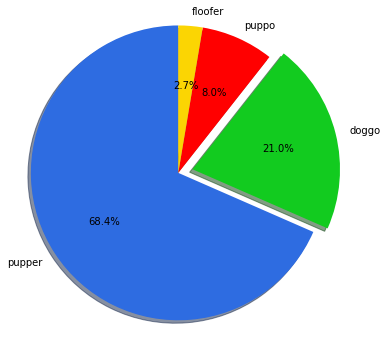

In [107]:
plt.figure(figsize = (6, 6))
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

colors=['#2E6CE1','#12CB1F','#FF0000','#FBD503']
plt.pie(x,labels=x.index, colors=colors,explode = explode, autopct='%1.1f%%',shadow=True, startangle=90)
plt.axis('equal')

plt.savefig('Dogs_num_per_dog_stage.png', dpi=100, bbox_inches='tight')
plt.show()


In [108]:
dog_stage = twitter_archive_master.groupby('dog_stage').mean()['rating_numerator']
dog_stage

dog_stage
doggo      11.772152
floofer    11.800000
pupper     11.341085
puppo      12.166667
Name: rating_numerator, dtype: float64

In [109]:
height = []
for dog in dog_stage.index:
    height.append(dog_stage[dog])
height

[11.772151898734178, 11.8, 11.34108527131783, 12.166666666666666]

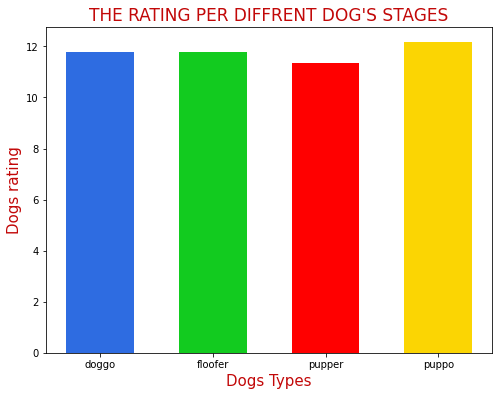

In [110]:
plt.figure(figsize = (8, 6))
plt.bar(dog_stage.index,height,width=0.6,color=colors)

plt.title("the rating per diffrent dog's stages".upper(), color='#C20808', fontsize=17)
plt.xlabel('Dogs Types',color='#C20808', fontsize=15)
plt.ylabel('Dogs rating',color='#C20808', fontsize=15)

plt.savefig('Rating_per_dog_stages.png', dpi=100, bbox_inches='tight')
plt.show()

<a id='two'></a>
### Insight two
1. [What is the most common dog's types?](#2.1)
2. [What is the average rating among dog's types?](#2.2)

In [111]:
dog_breed = pd.DataFrame(twitter_archive_master['predection'].value_counts())
dog_breed

,predection
golden_retriever,158
Labrador_retriever,108
Pembroke,95
Chihuahua,91
pug,62
toy_poodle,51
chow,48
Pomeranian,42
Samoyed,42
malamute,33


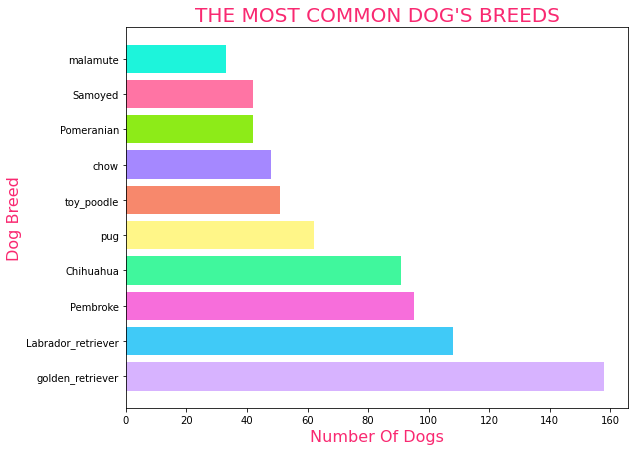

In [112]:
plt.figure(figsize = (9, 7))
colors = ['#D7B3FF','#40CAF7','#F76EDB','#40F79D','#FFF688','#F7886C','#A588FF','#8DEB18','#FF74A4','#1DF4DB']
plt.barh(dog_breed.index[:10],dog_breed.predection[:10],color=colors)

plt.title ("the most common dog's breeds".upper(),color='#F92971', fontsize=20)
plt.ylabel('dog breed'.title(),color='#F92971', fontsize=16)
plt.xlabel('number of dogs'.title(),color='#F92971', fontsize=16)

plt.savefig('dog_breed_counts.png', dpi=100, bbox_inches='tight')

plt.show()

In [113]:
avg_rating_per_type=twitter_archive_master.groupby('predection').mean().sort_values('rating')[:5]
avg_rating_per_type

,rating_numerator,rating_denominator,rating,retweet_count,favorite_count,img_num,confidance
predection,,,,,,,
Japanese_spaniel,5.00,10.0,0.500,383.00,1179.000000,1.000000,0.661178
soft-coated_wheaten_terrier,8.80,10.0,0.880,888.00,2952.866667,1.066667,0.418761
Scotch_terrier,9.00,10.0,0.900,1059.00,3162.000000,1.000000,0.267979
Walker_hound,9.00,10.0,0.900,2262.00,5828.200000,1.200000,0.424219
Tibetan_terrier,9.25,10.0,0.925,471.25,1638.000000,1.000000,0.408551


In [114]:
rating = avg_rating_per_type['rating'].tolist()
first_5_types = avg_rating_per_type.index
print(rating)
print()
print(first_5_types)

[0.5, 0.8800000000000001, 0.9, 0.9, 0.925]

Index(['Japanese_spaniel', 'soft-coated_wheaten_terrier', 'Scotch_terrier',
       'Walker_hound', 'Tibetan_terrier'],
      dtype='object', name='predection')


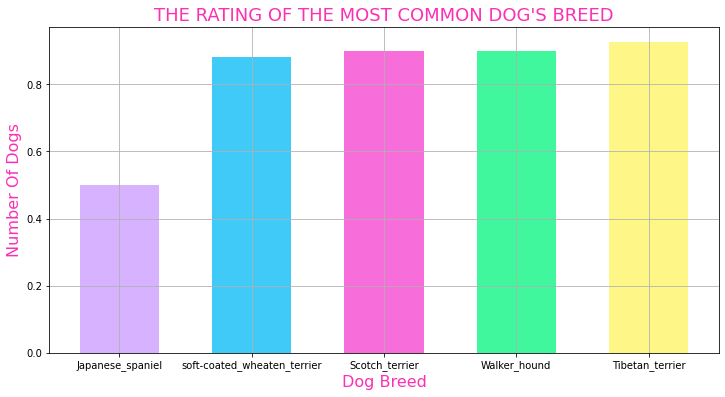

In [115]:

plt.figure(figsize = (12, 6))
colors = ['#D7B3FF','#40CAF7','#F76EDB','#40F79D','#FFF688','#F7886C','#A588FF','#8DEB18','#FF74A4','#1DF4DB']
plt.bar(first_5_types,rating,color=colors,width=0.6)

plt.title ("the rating of the most common dog's breed".upper(),color='#FB30B4', fontsize=18)
plt.xlabel('dog breed'.title(),color='#FB30B4', fontsize=16)
plt.ylabel('number of dogs'.title(),color='#FB30B4', fontsize=16)

plt.grid()
plt.savefig('ratings_per_dog_breed.png', dpi=100, bbox_inches='tight')
plt.show()

<a id='three'></a>
### Insight three
1. [what is the rating over time?](#3.1)

In [116]:
df=twitter_archive_master[['timestamp','rating','retweet_count' , 'favorite_count']]
df.head(5)

,timestamp,rating,retweet_count,favorite_count
0,2017-08-01 16:23:56+00:00,1.3,7446.0,35282.0
1,2017-08-01 00:17:27+00:00,1.3,5531.0,30524.0
2,2017-07-31 00:18:03+00:00,1.2,3658.0,22969.0
3,2017-07-30 15:58:51+00:00,1.3,7618.0,38566.0
4,2017-07-29 16:00:24+00:00,1.2,8211.0,36852.0


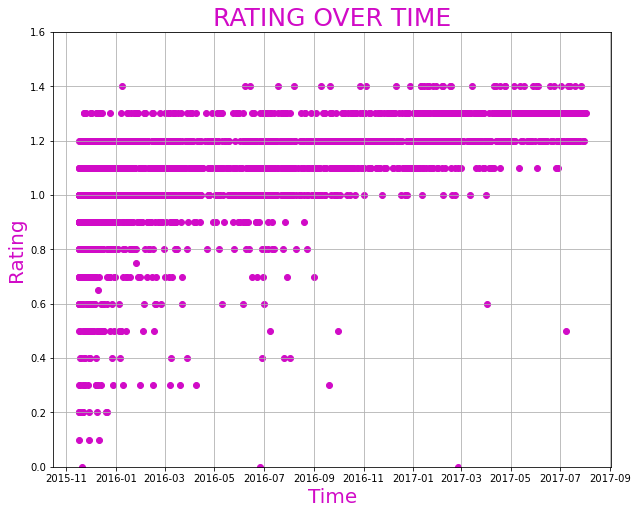

In [117]:
plt.figure(figsize=(10, 8))

plt.scatter(df.timestamp,df.rating,marker = 'o',color='#D10BC7')

plt.title('rating over time'.upper(), color='#D10BC7', fontsize=25)
plt.xlabel("Time", color='#D10BC7', fontsize=20)
plt.ylabel('Rating', color='#D10BC7', fontsize=20)
plt.ylim(0, 1.6)

plt.grid()
plt.savefig('rating_over_time.png', dpi=100, bbox_inches='tight')
plt.show()

<a id='four'></a>
### Insight four
1. [what is the relation between favorite_count and retweet_count?](#4.1)
2. [which dog type has the heighest number of likes and retweets?](#4.2)
3. [which age stage has the heighest number of likes and retweets?](#4.3)


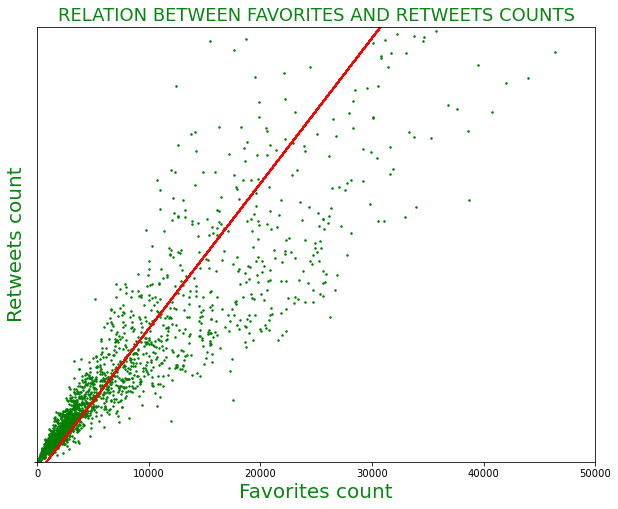

In [118]:
from pylab import *

plt.figure(figsize=(10, 8))
x = df.favorite_count.dropna()
y = df.retweet_count.dropna()
plt.plot(x,y,'go','',markersize=1.5)
#best fit line 
plt.plot(x, np.poly1d(np.polyfit(x, y, 1))(x),color ='#FF0000')

plt.title("relation between Favorites and Retweets counts".upper(), color='#0A8511', fontsize=18)
plt.xlabel('Favorites count', color='#0A8511', fontsize=20)
plt.ylabel('Retweets count', color='#0A8511', fontsize=20)

plt.xlim(0, 50000)
plt.ylim(0, 10000)

plt.savefig('likes_and_retweet.png', dpi=100, bbox_inches='tight')
plt.show()


In [119]:
df = twitter_archive_master.groupby('predection')[['favorite_count','retweet_count','jpg_url']].mean().sort_values(['favorite_count','retweet_count'],ascending=[0,0])[:10]
df

,favorite_count,retweet_count
predection,,
Bedlington_terrier,22560.333333,7083.333333
Saluki,21702.000000,4370.250000
French_bulldog,18314.500000,4656.533333
Bouvier_des_Flandres,16070.000000,3794.000000
Afghan_hound,15387.333333,5047.666667
black-and-tan_coonhound,15283.500000,3507.000000
flat-coated_retriever,15131.125000,3913.625000
Irish_water_spaniel,14607.333333,3825.333333
Leonberg,13254.333333,3267.666667


In [120]:
labels = df.index
likes_count = df['favorite_count'].tolist()
retweet_count = df['retweet_count'].tolist()

In [121]:
x = np.arange(len(labels))
width = 0.35

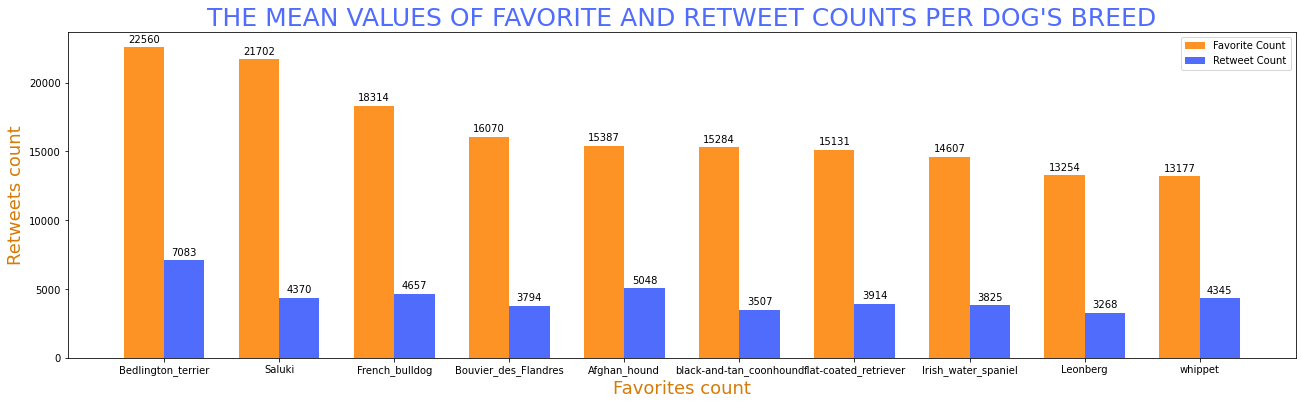

In [122]:
import matplotlib

fig, ax = plt.subplots(figsize=(22,6))

likes = ax.bar(x - width/2, likes_count, width,color ='#FC9324' , label='favorite count'.title())
retweets = ax.bar(x + width/2, retweet_count, width,color = '#4F6CFC',label='retweet count'.title())

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height())
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(likes)
autolabel(retweets)

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.set_xlabel('Favorites count', color='#D67B08', fontsize=18)
ax.set_ylabel('Retweets count', color='#D67B08', fontsize=18)
ax.set_title("the mean values of favorite and retweet counts per dog's breed".upper(),color='#4F6CFC', fontsize=25)

plt.savefig('likes_and_retweet_per_breed.png', dpi=100, bbox_inches='tight')
plt.show()

In [123]:
df = twitter_archive_master.groupby('dog_stage')[['favorite_count','retweet_count','jpg_url']].mean().sort_values(['favorite_count','retweet_count'],ascending=[0,0])[:10]
df

,favorite_count,retweet_count
dog_stage,,
puppo,21117.724138,5888.275862
doggo,16234.000000,5537.294872
floofer,10405.700000,3464.900000
pupper,6559.178295,2104.000000


In [124]:
labels = df.index
likes_count = df['favorite_count'].tolist()
retweet_count = df['retweet_count'].tolist()

In [125]:
x = np.arange(len(labels))
width = 0.35

<Figure size 1440x1080 with 0 Axes>

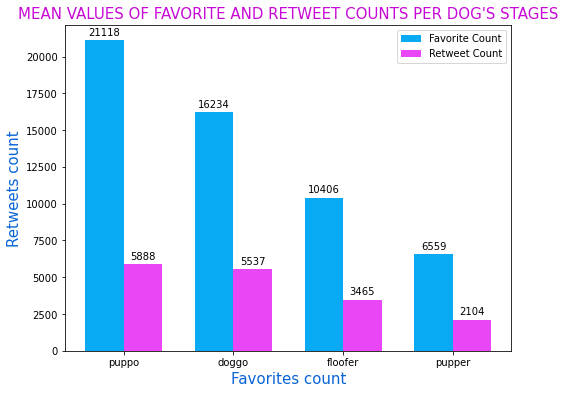

In [126]:
import matplotlib

plt.figure(figsize=(20, 15))
fig, ax = plt.subplots(figsize=(8,6))

likes = ax.bar(x - width/2, likes_count, width,color ='#07AAF3' , label='favorite count'.title())
retweets = ax.bar(x + width/2, retweet_count, width,color = '#E946F6',label='retweet count'.title())

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height())
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(likes)
autolabel(retweets)

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.set_xlabel('Favorites count', color='#0864D6', fontsize=15)
ax.set_ylabel('Retweets count', color='#0864D6', fontsize=15)
ax.set_title("mean values of favorite and retweet counts per dog's stages".upper(),color='#C708D6', fontsize=15)

plt.savefig('likes_and_retweet_per_stage.png', dpi=100, bbox_inches='tight')
plt.show()

<a id='five'></a>
### Insight five
1. [which dog heighest number of likes?](#5.1)
2. [which dog heighest number of retweets?](#5.2)

In [137]:
highest_likes = twitter_archive_master.query('favorite_count == favorite_count.max()')\
[['text','favorite_count','retweet_count','dog_stage','predection','name','jpg_url']]

highest_retweets = twitter_archive_master.query('retweet_count == retweet_count.max()')\
[['text','favorite_count','retweet_count','dog_stage','predection','name','jpg_url']]

In [138]:
pd.set_option('display.max_colwidth',None)
highest_likes

,text,favorite_count,retweet_count,dog_stage,predection,name,jpg_url
829,Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4,152062.0,75154.0,doggo,Labrador_retriever,NaN,https://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg


In [139]:
highest_retweets

,text,favorite_count,retweet_count,dog_stage,predection,name,jpg_url
829,Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4,152062.0,75154.0,doggo,Labrador_retriever,NaN,https://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg


In [140]:
highest_retweets == highest_likes

,text,favorite_count,retweet_count,dog_stage,predection,name,jpg_url
829,True,True,True,True,True,False,True


In [141]:
from PIL import Image
from io import BytesIO

url = highest_likes['jpg_url'].tolist()

In [142]:
from IPython.display import Image
Image(url = url[0])